In [1]:
import pydicom
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

> pydicom
https://pyscience.wordpress.com/2014/09/08/dicom-in-python-importing-medical-image-data-into-numpy-with-pydicom-and-vtk/


> Get Dicom File List

In [2]:
from os import walk
PathDicom = 'MRCT/DICOM/CT L1-L5 (1mm)/S3010/'
lstFilesDCM = []
# get all file name in a directory
for (dirpath, dirnames, filenames) in walk(PathDicom):
    lstFilesDCM.extend(filenames)
    break
for i in range(len(lstFilesDCM)):
    lstFilesDCM[i] = PathDicom + lstFilesDCM[i]
#print(lstFilesDCM)

> Get Dicom Ref

In [3]:
# Get ref file
RefDs = pydicom.read_file(lstFilesDCM[0])
# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))
print (ConstPixelDims)
# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))
print (ConstPixelSpacing)

(512, 512, 341)
(0.4375, 0.4375, 1.0)


> Dicom -> Array

In [4]:
# The array is sized based on 'ConstPixelDims'
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    # read the file
    ds = pydicom.read_file(filenameDCM)
    # store the raw image data
    ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array  

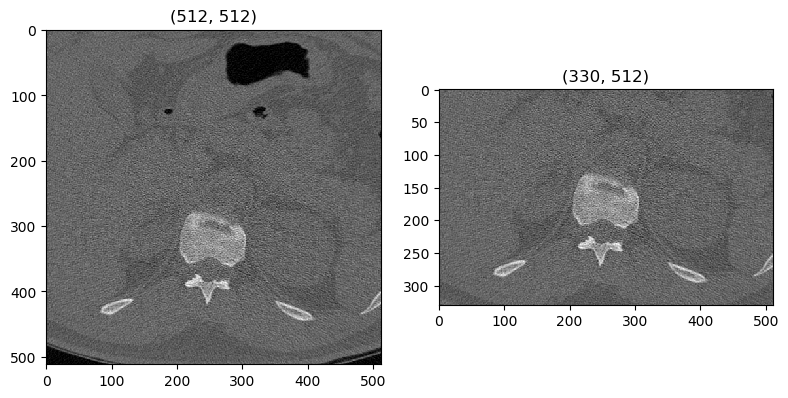

In [5]:
num = 0
DicomImg = ArrayDicom[:, :, num]
DicomImgCut = DicomImg[150:480, 0:512]

plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plt.subplot(121), plt.title(DicomImg.shape), plt.imshow(DicomImg, cmap='gray')
plt.subplot(122), plt.title(DicomImgCut.shape), plt.imshow(DicomImgCut, cmap='gray')
plt.tight_layout()
plt.show()

In [6]:
print (DicomImgCut)
print (np.dtype(DicomImgCut[0][0]))

# Normalised [0,1]
DicomImgCut_norm = (DicomImgCut - np.min(DicomImgCut)) / np.ptp(DicomImgCut) * 255
# uint8
DicomImgCut_norm = DicomImgCut_norm.astype(np.uint8)
print (DicomImgCut_norm)
print (np.amax(DicomImgCut_norm))
print (np.dtype(DicomImgCut_norm[0][0]))

[[ 996  979  945 ...  896  963 1104]
 [ 945 1063 1156 ...  951 1002 1044]
 [ 967 1096 1231 ...  886  829  922]
 ...
 [1075 1055 1156 ... 1100  997 1138]
 [ 859 1011 1212 ... 1238 1125 1075]
 [ 643  729  860 ... 1195 1204  971]]
uint16
[[ 94  92  89 ...  84  91 104]
 [ 89 100 109 ...  90  94  98]
 [ 91 103 116 ...  83  78  87]
 ...
 [101  99 109 ... 104  94 107]
 [ 81  95 114 ... 117 106 101]
 [ 60  69  81 ... 113 114  92]]
255
uint8


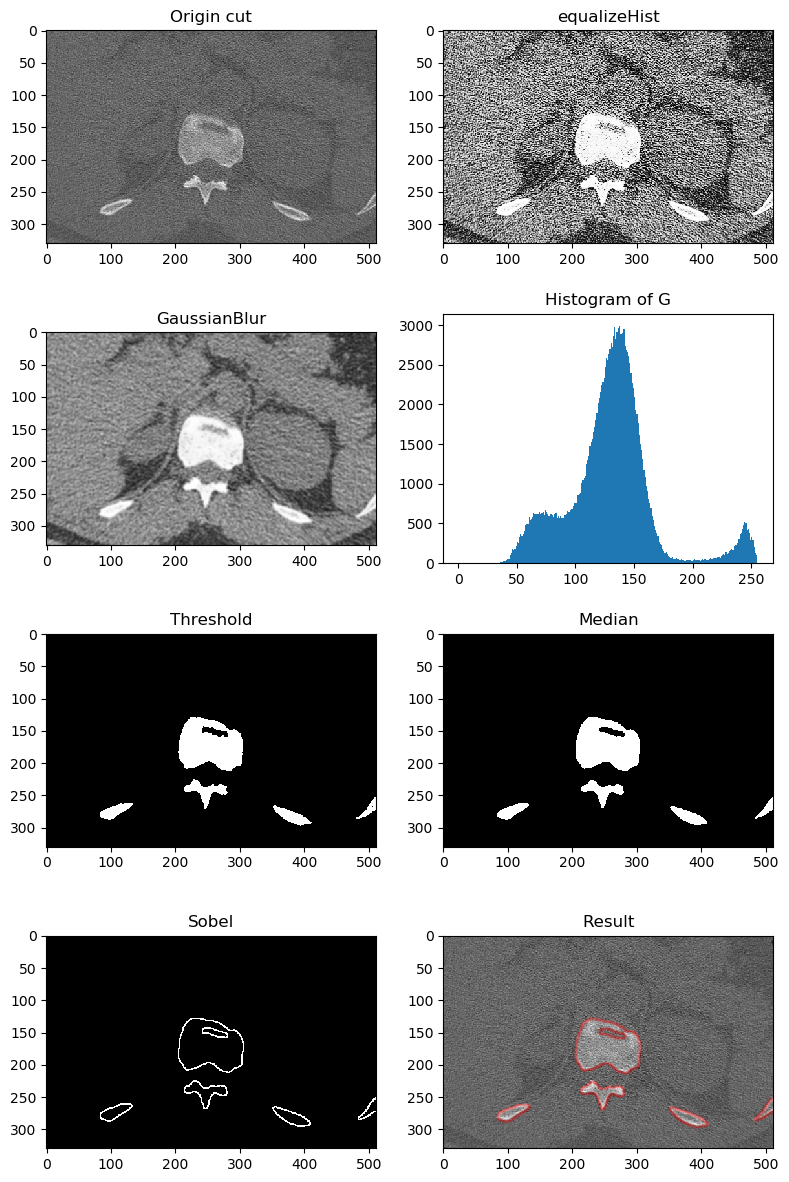

In [7]:
plt.figure(num=None, figsize=(8, 15), dpi=100, facecolor='w', edgecolor='k')

# Origin
plt.subplot(521), plt.title('Origin cut'), plt.imshow(DicomImgCut_norm, cmap='gray')

# Histograms Equalization
DicomImgCut_HE = cv2.equalizeHist(DicomImgCut_norm)
plt.subplot(522), plt.title('equalizeHist'), plt.imshow(DicomImgCut_HE, cmap='gray')

# GaussianBlur
DicomImgCut_G = cv2.GaussianBlur(DicomImgCut_HE,(7,7),0,0)
plt.subplot(523), plt.title('GaussianBlur'), plt.imshow(DicomImgCut_G, cmap='gray')

# Histogram
plt.subplot(524), plt.title('Histogram of G'), plt.hist(DicomImgCut_G.ravel(),256,[0,256])

# Threshold
DicomImgCut_T = (DicomImgCut_G > 200) * 255
DicomImgCut_T = DicomImgCut_T.astype(np.uint8)
plt.subplot(525), plt.title('Threshold'), plt.imshow(DicomImgCut_T, cmap='gray')

# MedianBlur
DicomImgCut_MED = cv2.medianBlur(DicomImgCut_T, 7)
plt.subplot(526), plt.title('Median'), plt.imshow(DicomImgCut_MED, cmap='gray')

# Sobel
sobelx = cv2.Sobel(DicomImgCut_MED,cv2.CV_64F,1,0,ksize=3)  # x
sobely = cv2.Sobel(DicomImgCut_MED,cv2.CV_64F,0,1,ksize=3)  # y
absX = cv2.convertScaleAbs(sobelx) 
absY = cv2.convertScaleAbs(sobely)
DicomImgCut_S = cv2.addWeighted(absX,1,absY,1,0)
plt.subplot(527), plt.title('Sobel'), plt.imshow(DicomImgCut_S, cmap='gray')

# Result
x,y = np.argwhere(DicomImgCut_S == 255).T
plt.subplot(528), plt.title('Result'), plt.imshow(DicomImgCut_norm, cmap='gray')
plt.scatter(y, x, marker='.', c='r', s=0.01)

plt.tight_layout()
plt.show()